### Load libraries

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import time
import pickle
from matplotlib import pyplot as plt

from sklearn.metrics import roc_curve, auc

from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.models import load_model

path_main_folder = '/home/antorosi/Documents/Prediction'
sys.path.append(path_main_folder)

from conso.load_shape_data import load_data_conso, get_uniformed_data_conso, change_granularity, get_x_y_prediction_conso, get_train_test_sets, normalized_dataset, select_variables, add_atypical_events_to_dict_data_conso
from models.feedforward_NN import FeedForward
from aed.detection import get_next_hd_events, sort_atypical_events, get_residuals, get_atypical_score, get_atypical_ds, prediction_conso_plot, aed_conso_plot
from aed.atypical_event import AtypicalEvent, AtypicalEventsList, get_atypical_events_list, apply_ael_to_df, get_confusion_matrix
from aed.verification import *
from aed.multi_period import get_prediction_results, get_aed_results, get_complete_df

### Get original data 

In [3]:
# Load
path_data = os.path.join(path_main_folder, 'data')
dict_data_conso = load_data_conso(path_data)

# Uniformization
data_conso_df, dict_colnames_conso = get_uniformed_data_conso(dict_data_conso)

# Granularity from 15 min to 1H
data_conso_df = change_granularity(data_conso_df, granularity="1H")

### Multi period prediction and aed results

In [4]:
# model paths
# cv_cmca_model_rf_0
path_models_folder = os.path.join(path_main_folder, 'out', 'cv_model_1.2')
name_dict_dataset = 'dict_datasets.pickle'
name_model = 'FFNN'
type_model = 'keras'
type_info = 'cmca'

In [5]:
# get prediction results
mode = 4
prediction_results = get_prediction_results(path_models_folder, name_dict_dataset, mode=mode, type_model=type_model)

In [6]:
# get atypical events info
threshold = 0.9
aed_results, ael_full_model = get_aed_results(prediction_results, threshold)

### Comparing results with reference and getting scores 

In [7]:
# Loading list
path_data = os.path.join("/local/home/antorosi/Documents/Prediction/data")
#with open(os.path.join(path_data, 'ae_reference_list_wwe_2013-2017' + '.pickle'), 'rb') as f:
#    ael_reference= pickle.load(f)
    
with open(os.path.join(path_data, 'ae_reference_list_2013-2017' + '.pickle'), 'rb') as f:
    ael_reference= pickle.load(f)

In [8]:
ael_results = ael_reference.strict_comparison(ael_full_model)

In [9]:
#ael_results.get_events_list()

In [10]:
nb_events = 1825

In [11]:
dict_confusion_matrix = get_confusion_matrix(ael_results, nb_events)

In [12]:
dict_confusion_matrix

{'a': 46, 'b': 25, 'c': 9, 'd': 1745}

In [13]:
get_all_scores(dict_confusion_matrix)

{'csi': 0.575,
 'f': 0.014124293785310734,
 'f1': 0.7301587301587301,
 'far': 0.352112676056338,
 'gss': 0.5633203138745205,
 'h': 0.8363636363636363,
 'hss': 0.7206716485099495,
 'pc': 0.9813698630136987,
 'ppv': 0.647887323943662,
 'pss': 0.8222393425783255}

### Plotting results 

In [14]:
# getting complete dataframe
atypical_full_df, prediction_full_df = get_complete_df(prediction_results, aed_results)

In [15]:
# applying verification to df
atypical_full_df = apply_ael_to_df(atypical_full_df, ael_results)

In [16]:
# get infos about top atypical days
pd.options.display.max_rows = 200
atypical_new_df = sort_atypical_events(atypical_full_df, ael_reference)
atypical_new_df.head(200)


,ds,residuals,z_score,a_score,is_atypical,type_event
0,2014-12-25,-1413.269531,-6.505473,1.000000,1.0,1
1,2013-01-01,-413.066406,-6.454401,1.000000,1.0,1
2,2013-05-01,599.417969,-6.283777,1.000000,1.0,1
3,2017-12-25,849.480469,-6.204172,1.000000,1.0,1
4,2016-11-11,-112.882812,-6.113298,1.000000,1.0,1
5,2016-01-01,-730.242188,-6.051544,1.000000,1.0,1
6,2013-12-25,-293.476562,-6.046483,1.000000,1.0,1
7,2014-05-01,-129.984375,-5.777559,1.000000,1.0,1
8,2015-05-01,-399.882812,-5.714612,1.000000,1.0,1
9,2015-12-25,-937.531250,-5.713959,1.000000,1.0,1


In [17]:
df_plot = atypical_new_df.head(200).copy()
df_plot['ind'] = np.array(range(200))

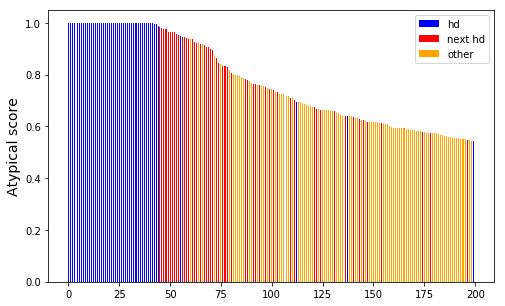

In [18]:
fig = plt.figure(figsize=(8,5))

type_model = name_model

width = 0.5
idx = 0
epsilon = 0

mask = df_plot['type_event']==1
df_plot_mask = df_plot[mask]

ind = df_plot_mask['ind']
plt.bar(ind, df_plot_mask['a_score'], width, label='hd', color = 'blue',align = 'edge')

mask = df_plot['type_event']==-1
df_plot_mask = df_plot[mask]

ind = df_plot_mask['ind']
plt.bar(ind, df_plot_mask['a_score'], width, label='next hd', color = 'red')

mask = df_plot['type_event'].isna()
df_plot_mask = df_plot[mask]

ind = df_plot_mask['ind']
plt.bar(ind, df_plot_mask['a_score'], width, label='other', color = 'orange')

plt.legend()
plt.ylabel('Atypical score', size=14)
#plt.title('{}: type of top atypical events sorted by atypical score'.format(type_model))

path_save = os.path.join(path_main_folder, 'out', 'figures')
name_fig = '{}_mode-{}_info-{}_top_atypical_events'.format(type_model,mode,type_info)
plt.savefig(os.path.join(path_save, name_fig + '.png'))
plt.savefig(os.path.join(path_save, name_fig + '.pdf'))

plt.bar(true_ind, ae_results['nb_hd_tot'], width, label='hd', color = 'blue')
plt.bar(true_ind, ae_results['nb_other_tot'], width,
             bottom=ae_results['nb_hd_tot'], label ='other', color = 'orange')

plt.ylabel('number of events')
plt.xlabel('iteration')
plt.title('Total Atypical Events detected vs iteration')
#plt.yticks(np.arange(0, 101, 10))
plt.legend()

total = ae_results['nb_tot']

plt.text(true_ind[0], total[0]+5, name_model, rotation=90, verticalalignment='bottom')

idx += 1
    
plt.legend(['hd', 'other'])
plt.xticks(ind+width+epsilon, [str(el) for el in list(ind)])


In [19]:
# plotting
path_plot = '/home/antorosi/Documents/Prediction/out/figures'
name_plot = 'full_period_mode2_cmcah_t0.98.html'

# prediction_conso_plot(data_conso_df, atypical_full_df, prediction_full_df, dict_colnames_conso, path_plot, name_plot)
aed_conso_plot(data_conso_df, atypical_full_df, prediction_full_df, dict_colnames_conso, path_plot, name_plot)

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]
[ (4,1) x1,y4 ]



'file:///home/antorosi/Documents/Prediction/out/figures/full_period_mode2_cmcah_t0.98.html'

# data_conso_df

### Knee technique 

In [105]:
a_score_df  = atypical_full_df[['a_score','ds']].copy()

In [106]:
a_score_df = a_score_df.sort_values('a_score')

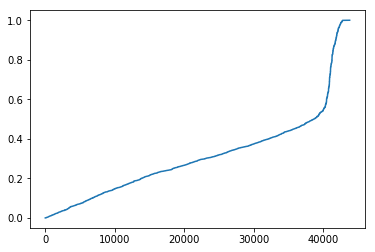

In [107]:
plt.plot(np.array(a_score_df.a_score))

### Wrong results analysis 

In [180]:
results_df = ael_results.get_events_list().copy()

In [181]:
results_df['is_week_day']= np.array(results_df.date_start.dt.dayofweek <5).astype(int)

In [182]:
# week end

mask = (results_df.is_week_day==0) & (results_df.is_atypical==1)
nb_tp_we = len(results_df[mask])

mask = (results_df.is_week_day==0) & (results_df.is_atypical==-1)
nb_fn_we = len(results_df[mask])

nb_hd_we = nb_tp_we+nb_fn_we

print('holiday day on week end: ' + str(nb_hd_we))
print('holiday day on week end detected: ' + str(nb_tp_we))


holiday day on week end: 9
holiday day on week end detected: 1


##### Get dependance with threshold

In [151]:
list_threshold = [0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.70, 0.75,0.8,0.85,0.88,0.9,0.92,0.94,0.95,0.96,0.97,0.98,0.99,1]  

In [152]:
# initialization
threshold = list_threshold[0]
aed_results, ael_full_model = get_aed_results(prediction_results, threshold)
ael_results = ael_reference.strict_comparison(ael_full_model)
dict_confusion_matrix = get_confusion_matrix(ael_results, nb_events)
dict_result = get_all_scores(dict_confusion_matrix)

results_df = ael_results.get_events_list().copy()
results_df['is_week_day']= np.array(results_df.date_start.dt.dayofweek <5).astype(int)
mask = (results_df.is_week_day==0) & (results_df.is_atypical==1)
nb_tp_we = len(results_df[mask])

dict_results = {}
dict_results['nb_tp_we'] = [nb_tp_we]
for key, value in dict_result.items():
    dict_results[key] = [value]

# loop
for threshold in list_threshold[1:]:
    aed_results, ael_full_model = get_aed_results(prediction_results, threshold)
    ael_results = ael_reference.strict_comparison(ael_full_model)
    dict_confusion_matrix = get_confusion_matrix(ael_results, nb_events)
    dict_result = get_all_scores(dict_confusion_matrix)
    
    if threshold == 1:
        dict_result['far']=0

    results_df = ael_results.get_events_list().copy()
    results_df['is_week_day']= np.array(results_df.date_start.dt.dayofweek <5).astype(int)
    mask = (results_df.is_week_day==0) & (results_df.is_atypical==1)
    nb_tp_we = len(results_df[mask])

    dict_results['nb_tp_we'].append(nb_tp_we)
    for key, value in dict_result.items():
        dict_results[key].append(value)

dict_results['threshold'] = list_threshold

In [153]:
dict_results['nb_tp_we']

[9, 9, 9, 9, 6, 6, 5, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]

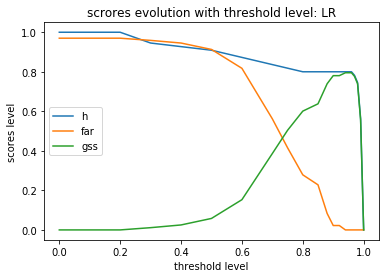

In [154]:
fig = plt.figure()

#plt.plot(dict_results['threshold'],[el/9 for el in dict_results['nb_tp_we']], label=('nb_tp_we'))
plt.plot(dict_results['threshold'],dict_results['h'], label='h')
plt.plot(dict_results['threshold'],dict_results['far'], label='far')
plt.plot(dict_results['threshold'],dict_results['gss'], label='gss')

plt.legend()
plt.title('scrores evolution with threshold level: ' + name_model)
plt.xlabel('threshold level')
plt.ylabel('scores level')
plt.show()

In [129]:
path_plot = '/home/antorosi/Documents/Prediction/out/figures'
name_plot = 'Score_evolution_wwe_t_' + name_model +'.png'

fig.savefig(fname=os.path.join(path_plot, name_plot))

In [156]:
 roc_auc = auc(dict_results['f'], dict_results['h'])

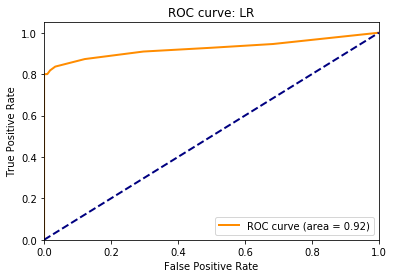

In [157]:
fig = plt.figure()
lw = 2

plt.plot(dict_results['f'], dict_results['h'], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: ' + name_model)
plt.legend(loc="lower right")

plt.show()


In [158]:
path_plot = '/home/antorosi/Documents/Prediction/out/figures'
name_plot = 'ROC_wwe_' + name_model + '.png'

fig.savefig(os.path.join(path_plot, name_plot))

In [273]:
list_threshold = [0.90,0.91,0.92,0.93,0.94, 0.95,0.96,0.97,0.975,0.98,0.982,0.984,0.986,0.988,0.99, 0.992,0.994,0.996,0.998,0.999,1]  
dict_results = get_all_scores_multi_t(list_threshold, prediction_results, ael_reference, nb_events)

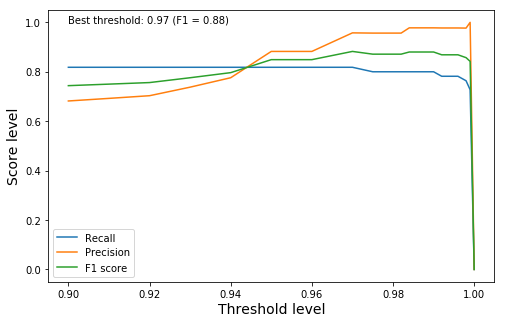

In [274]:
fig = plt.figure(figsize=(8,5))

#plt.plot(dict_results['threshold'],[el/9 for el in dict_results['nb_tp_we']], label=('nb_tp_we'))
plt.plot(dict_results['threshold'],dict_results['h'], label='Recall')
plt.plot(dict_results['threshold'],dict_results['ppv'], label='Precision')
plt.plot(dict_results['threshold'],dict_results['f1'], label='F1 score')

best_f1 = max(dict_results['f1'])
indice = dict_results['f1'].index(best_f1)
best_t = dict_results['threshold'][indice]

plt.text(0.90, 1, "Best threshold: {} (F1 = {:.2f})".format(best_t,best_f1),size = 10)


plt.legend(loc = 'lower left')
plt.xlabel('Threshold level', size = 14)
plt.ylabel('Score level', size = 14)
plt.show()

In [275]:
path_plot = '/home/antorosi/Documents/Prediction/out/figures'
name_plot = 'Score_evolution_zoom_t_mode_' + str(mode) + '_' + name_model

fig.savefig(fname=os.path.join(path_plot, name_plot + '.png'))
fig.savefig(fname=os.path.join(path_plot, name_plot + '.pdf'))

Text(0.5,0,'Evaluation of atypicality')

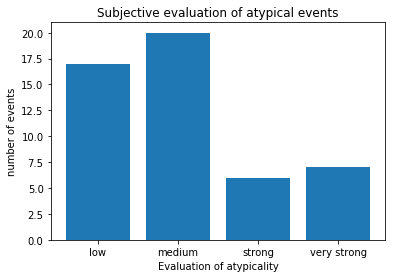

In [132]:
a = [17,20,6,7]
b = ['low', 'medium','strong','very strong']

fig, ax = plt.subplots()
ax.bar([1,2,3,4],a)
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(b, rotation=0)

ax.set_title('Subjective evaluation of atypical events')
ax.set_ylabel('number of events')
ax.set_xlabel('Evaluation of atypicality')




In [133]:
path_plot = '/home/antorosi/Documents/Prediction/out/figures'
name_plot = 'Subjective_Evaluation_Top_Ae.png'

fig.savefig(fname=os.path.join(path_plot, name_plot))